In [15]:
import pandas as pd
import numpy as np

In [2]:
# load the csv file for analysis
df = pd.read_csv('resources/athlete_events.csv')

# use only the Summer Olympics for Analysis
summer_df = df[df['Season'] == 'Summer']

In [3]:
# create a dataframe for only the Chinese team in the Summer Olympics
china_df = summer_df[summer_df['Team'] == 'China']

# create a dataframe for every team except China in the Summer Olympics
rest_of_world_df = summer_df[summer_df['Team'] != 'China']


In [4]:
# create a dataframe for the Chinese team in the Summer Olympics grouped by Games. 
games_df_china = china_df.groupby('Games').agg({'Medal': ['count']})

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
games_df_china['gold_medals'] = china_df[china_df['Medal'] == 'Gold'].groupby('Games').agg({'Medal': ['count']})
games_df_china['silver_medals'] = china_df[china_df['Medal'] == 'Silver'].groupby('Games').agg({'Medal': ['count']})
games_df_china['bronze_medals'] = china_df[china_df['Medal'] == 'Bronze'].groupby('Games').agg({'Medal': ['count']})

# fill NaN values with 0
games_df_china = games_df_china.fillna(0)

# format values in all columns except Games to integers
games_df_china = games_df_china.astype(int)

games_df_china

,Medal,gold_medals,silver_medals,bronze_medals
,count,,,
Games,,,,
1932 Summer,0,0,0,0
1936 Summer,0,0,0,0
1948 Summer,0,0,0,0
1952 Summer,0,0,0,0
1984 Summer,74,24,13,37
1988 Summer,50,4,16,30
1992 Summer,70,14,41,15
1996 Summer,94,13,66,15


In [5]:
# Add a column for non-medal participations, which is the count of all rows for Games where Medal is NaN
games_df_china['non_medal_participations'] = china_df[china_df['Medal'].isnull()].groupby('Games').size()

# Add a column for total participations, which is the count of all rows for Games.
# This includes 0 or NaN values for medals
games_df_china['total_participations'] = china_df.groupby('Games').size()
games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,non_medal_participations,total_participations
,count,,,,,
Games,,,,,,
1932 Summer,0,0,0,0,2,2
1936 Summer,0,0,0,0,65,65
1948 Summer,0,0,0,0,33,33
1952 Summer,0,0,0,0,1,1
1984 Summer,74,24,13,37,249,323
1988 Summer,50,4,16,30,373,423
1992 Summer,70,14,41,15,308,378
1996 Summer,94,13,66,15,324,418


In [7]:
# Create a column called 'medal_rate' which is the ratio of medal count to total participation count
games_df_china['medal_rate'] = games_df_china['Medal']['count'] / games_df_china['total_participations']
games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,non_medal_participations,total_participations,medal_rate
,count,,,,,,
Games,,,,,,,
1932 Summer,0,0,0,0,2,2,0.000000
1936 Summer,0,0,0,0,65,65,0.000000
1948 Summer,0,0,0,0,33,33,0.000000
1952 Summer,0,0,0,0,1,1,0.000000
1984 Summer,74,24,13,37,249,323,0.229102
1988 Summer,50,4,16,30,373,423,0.118203
1992 Summer,70,14,41,15,308,378,0.185185
1996 Summer,94,13,66,15,324,418,0.224880


In [8]:
# create columns called gold_percentage, silver_percentage, bronze_percentage and non_medal_percentage
games_df_china['gold_percentage'] = games_df_china['gold_medals'] / games_df_china['Medal']['count']
games_df_china['silver_percentage'] = games_df_china['silver_medals'] / games_df_china['Medal']['count']
games_df_china['bronze_percentage'] = games_df_china['bronze_medals'] / games_df_china['Medal']['count']
games_df_china['non_medal_percentage'] = games_df_china['non_medal_participations'] / games_df_china['total_participations']

games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage
,count,,,,,,,,,,
Games,,,,,,,,,,,
1932 Summer,0,0,0,0,2,2,0.000000,NaN,NaN,NaN,1.000000
1936 Summer,0,0,0,0,65,65,0.000000,NaN,NaN,NaN,1.000000
1948 Summer,0,0,0,0,33,33,0.000000,NaN,NaN,NaN,1.000000
1952 Summer,0,0,0,0,1,1,0.000000,NaN,NaN,NaN,1.000000
1984 Summer,74,24,13,37,249,323,0.229102,0.324324,0.175676,0.500000,0.770898
1988 Summer,50,4,16,30,373,423,0.118203,0.080000,0.320000,0.600000,0.881797
1992 Summer,70,14,41,15,308,378,0.185185,0.200000,0.585714,0.214286,0.814815
1996 Summer,94,13,66,15,324,418,0.224880,0.138298,0.702128,0.159574,0.775120


<Axes: xlabel='Games'>

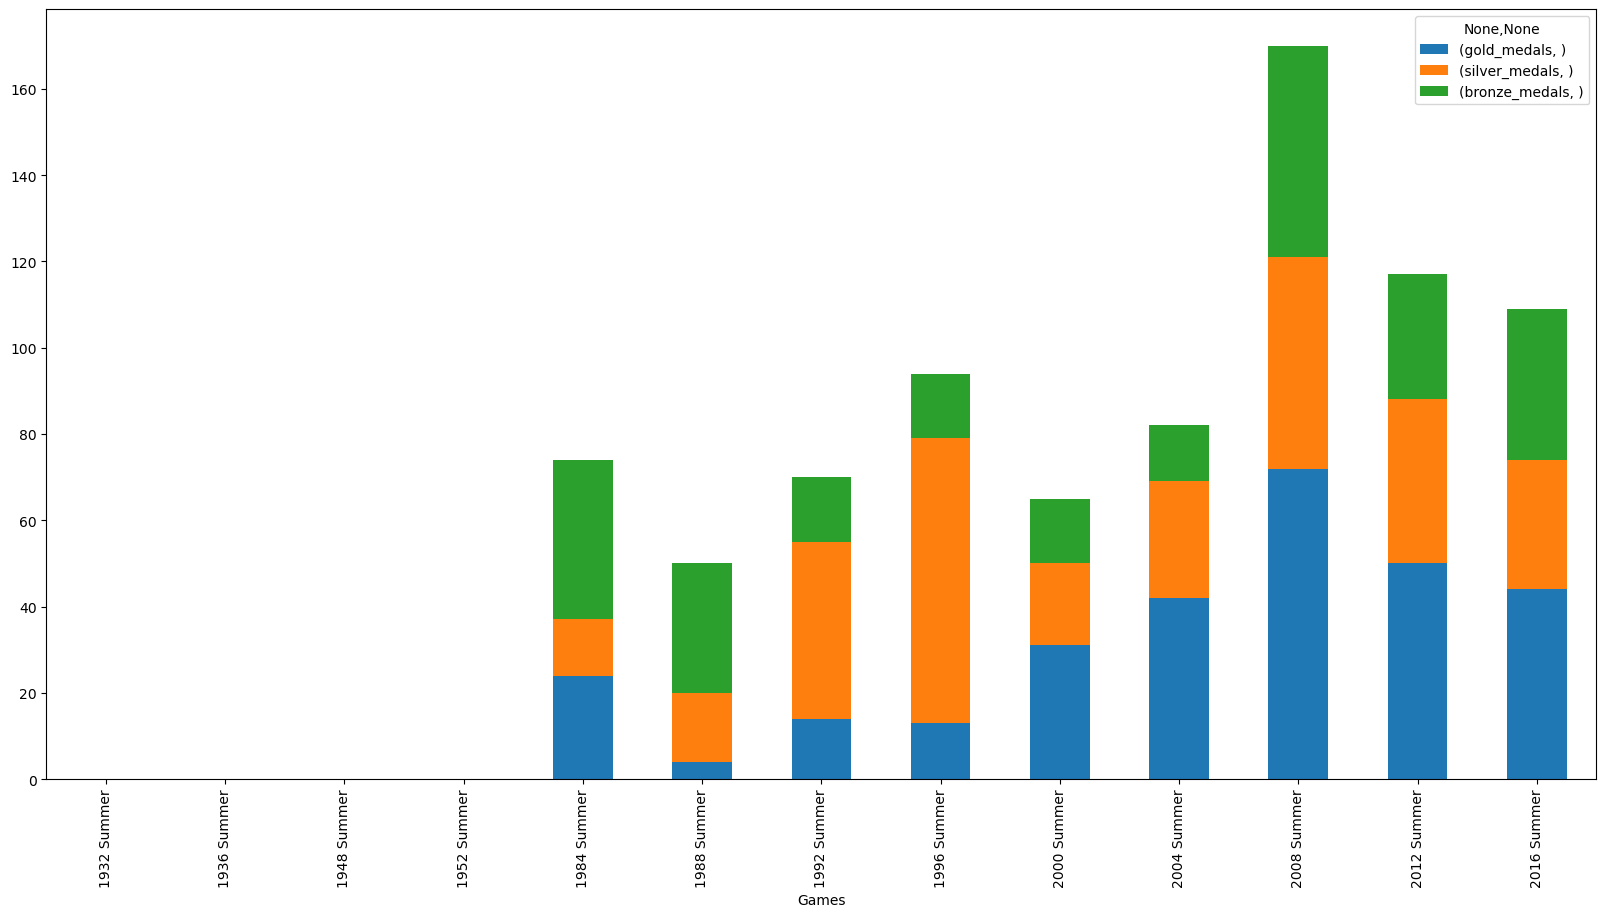

In [10]:
# Plot the gold_medals, silver_medals, bronze_medals and non_medal_participations for the Chinese team in the Summer Olympics.
# Use a stacked bar chart, where the total size of the bar is the total_participations

import matplotlib.pyplot as plt
games_df_china[['gold_medals', 'silver_medals', 'bronze_medals']].plot(kind='bar', stacked=True, figsize=(20, 10))


<Axes: xlabel='Games'>

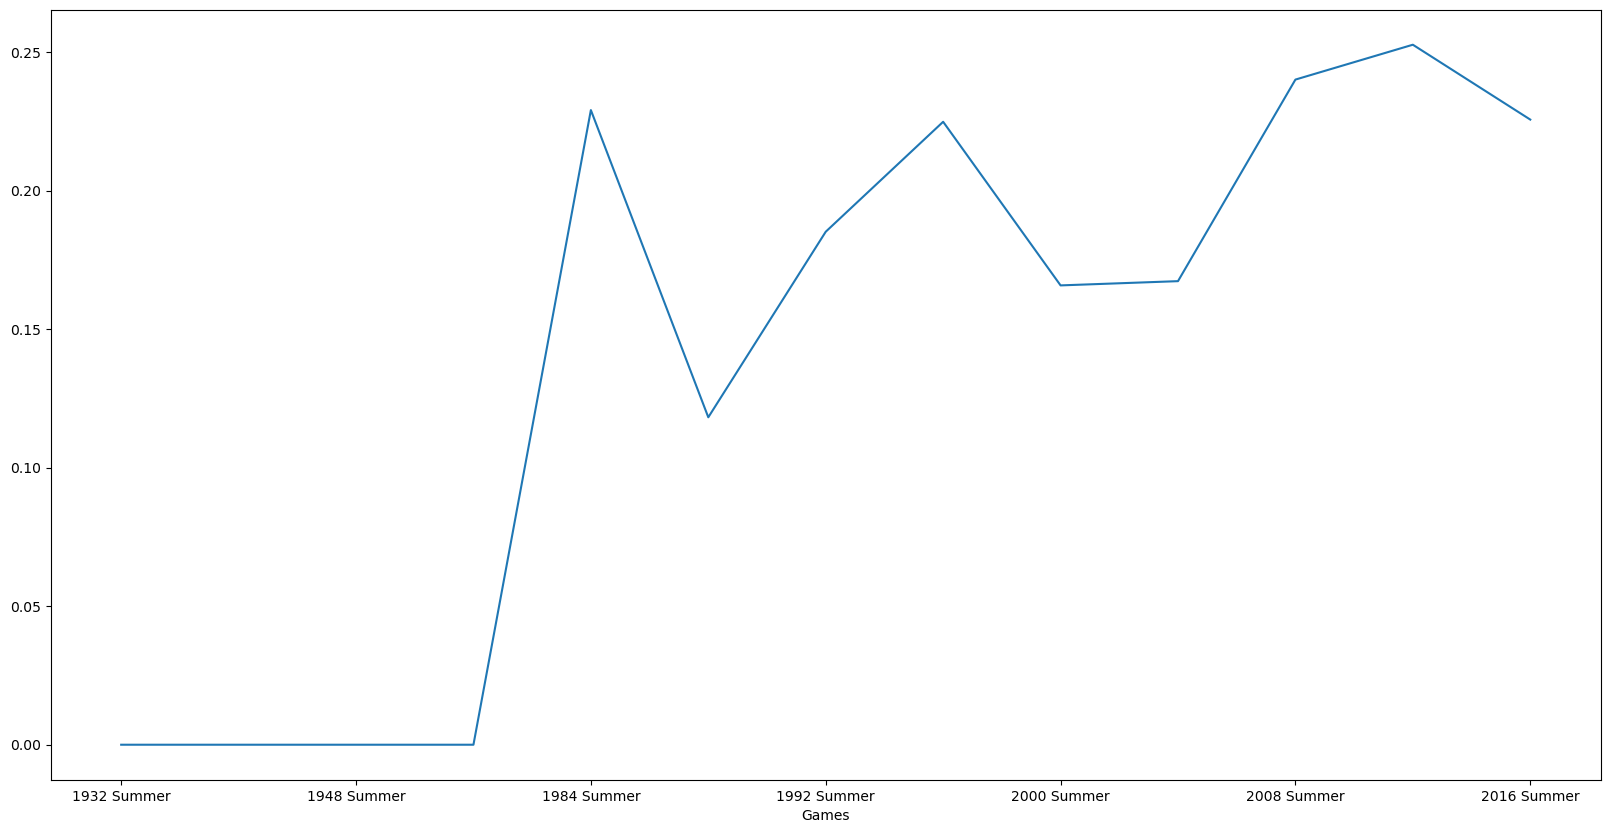

In [11]:
# Use a line chart to plot the medal_rate for the Chinese team in the Summer Olympics.
games_df_china['medal_rate'].plot(kind='line', figsize=(20, 10))

<Axes: xlabel='Games'>

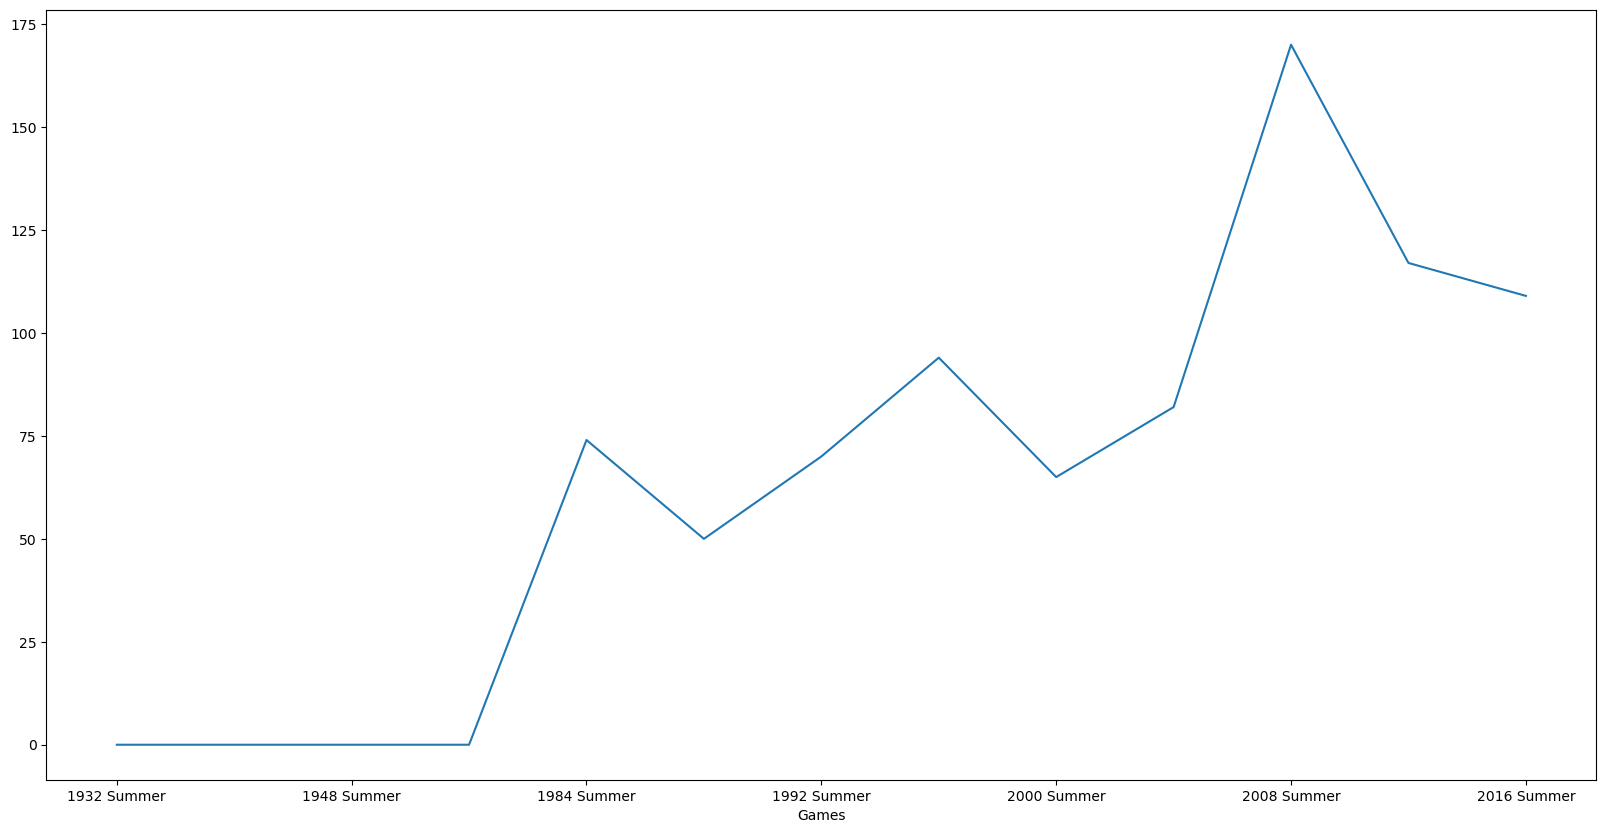

In [16]:
# Use a line chart to plot the medal count for the Chinese team in the Summer Olympics.
games_df_china['Medal']['count'].plot(kind='line', figsize=(20, 10))

